In [3]:
import torch
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader
import torch

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.layers import Dense, BatchNormalization

# from tqdm import tqdm
from sklearn.svm import OneClassSVM

# sys.path.append('../../')
from data_utils import *

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [4]:
features_sig=pd.read_hdf("/clusterfs/ml4hep/bpnachman/Anomalies/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/clusterfs/ml4hep/bpnachman/Anomalies/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [5]:
device = torch.device('cuda:0')

In [6]:
dataset_bg=load_data(features_bg)
dataset_sig=load_data(features_sig)

SR_low = 3.3
SR_high = 3.7

SB_low = 2.4
SB_high = 4.6

SR, SB = extract_regions(SR_low, SR_high, SB_low, SB_high, dataset_bg, dataset_sig)
(X_bg_SR, X_sig_SR) = SR
(X_bg_SB, X_sig_SB) = SB

In [7]:
def split_data(data):
    n = len(data)
    train_size = int(n*0.80)
    test_size = int(n*0.20)
    train_data = X_bg_SR[:train_size,:]
    test_data = X_bg_SR[-test_size:,:]
    return train_data, test_data

In [8]:
X_train, X_bg_test = split_data(X_bg_SR) ## all background
y_train = np.zeros(len(X_train))
y_bg_test = np.zeros(len(X_bg_test))

X_sig = X_sig_SR ## all signal
y_sig = np.ones(len(X_sig))

X_test = np.concatenate((X_bg_test, X_sig))
y_test = np.concatenate((y_bg_test, y_sig))

In [9]:
def make_torch_data_loader(data1, label1, data2=[], label2=None, shuffle=True, batch_size=50):
    
    data1 = torch.Tensor(data1)
    data2 = torch.Tensor(data2)
    
    data = []
    
    for i in range(len(data1)):
        data.append((data1[i], label1, i))
        
    for i in range(len(data2)):
        data.append((data2[i], label2, i))

    return DataLoader(data, batch_size=batch_size, shuffle=shuffle)

x_train_loader = make_torch_data_loader(X_train, 0)
x_test_loader = make_torch_data_loader(X_bg_test, 0, X_sig, 1, False)

In [8]:
def make_plots(ax1, ax2, scores_arr, y_test, model_name, baseline=True):
    
    for i in range(len(scores_arr)):
        fpr, tpr, _ = roc_curve(y_test, scores_arr[i])
        ax1.plot(fpr, tpr, label="Network: {0}".format(i))
        ax2.plot(tpr, tpr/np.sqrt(fpr), label="Network: {0}".format(i))
    
    ax1.set_title(model_name + " ROC Curve")
    if baseline:
        ax1.plot([0,1],[0,1],'--',label="baseline")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.legend()

    ax2.set_title(model_name + " SIC Curve")
    ax2.set_xlabel("True Positive Rate")
    ax2.set_ylabel("TPR/Sqrt(FPR)")
    ax2.legend()

In [134]:
def make_avg_plots(ax1, ax2, scores_arr, y_hat, model_name, baseline=True, std=False):

    x_const = np.linspace(0,1,100)
    roc_curves = np.zeros((len(scores_arr), len(x_const)))
    sic_curves = np.zeros((len(scores_arr), len(x_const)))
    
    for i in range(len(scores_arr)):
        fpr, tpr, _ = roc_curve(y_hat, scores_arr[i])
        roc_curves[i] = np.interp(x_const, fpr, tpr)
        sic_curves[i] = np.interp(x_const, tpr, tpr/np.sqrt(fpr))
        
        #ax1.plot(tpr, fpr, label="Network: {0}".format(i))
        #ax2.plot(tpr, tpr/np.sqrt(fpr), label="Network: {0}".format(i))
    
    avg_roc = np.mean(roc_curves, axis=0)
    avg_sic = np.mean(sic_curves, axis=0)
    
    
    ax1.set_title("Average ROC Curve")
    ax1.plot(x_const, avg_roc, label=model_name)
    
    if baseline:
        ax1.plot([0,1],[0,1],'--',label="baseline")
        
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.legend()  

    ax2.set_title("Average SIC Curve")
    ax2.plot(x_const, avg_sic, label=model_name)
    ax2.set_xlabel("True Positive Rate")
    ax2.set_ylabel("TPR/Sqrt(FPR)")
    ax2.legend()
    
    if std:
        std_roc = np.std(roc_curves, axis=0)
        std_sic = np.std(sic_curves, axis=0)
        ax1.fill_between(x_const, avg_roc-std_roc, avg_roc+std_roc, alpha=0.3)
        ax2.fill_between(x_const, avg_sic-std_sic, avg_sic+std_sic, alpha=0.3)

In [77]:
def make_single_plot(ax1, ax2, scores, y_test, model_name, baseline=True):
    
    
    fpr, tpr, _ = roc_curve(y_test, scores)
    
    ax1.plot(fpr, tpr, label="{0}".format(model_name))
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.legend()
    
    ax2.plot(tpr, tpr/np.sqrt(fpr), label="{0}".format(model_name))
    ax2.set_xlabel("True Positive Rate")
    ax2.set_ylabel("TPR/Sqrt(FPR)")
    ax2.legend()

# SVDD Model

In [11]:
sys.path.append('Deep-SVDD-PyTorch/src')
from deepSVDD import DeepSVDD

In [12]:
def make_and_test_SVDD(model_type, nu=15, epochs=20):
    models = [DeepSVDD(model_type, nu) for _ in range(5)]
    scores_arr = []
    
    for model in models:
        model.set_network("fc_net5")
        model.train(x_train_loader, n_epochs=epochs, device="cuda:0")
        model.test(x_test_loader)
        _, _, scores = zip(*model.results['test_scores'])
        scores_arr.append(np.array(scores))
        print()
    return models, scores_arr

10 Epochs Train

In [19]:
oc15_10, oc15_10_scores = make_and_test_SVDD('one-class', nu=0.15, epochs=10)
oc10_10, oc10_10_scores = make_and_test_SVDD('one-class', nu=0.10, epochs=10)

sb15_10, sb15_10_scores = make_and_test_SVDD('soft-boundary', nu=0.15, epochs=10)
sb10_10, sb10_10_scores = make_and_test_SVDD('soft-boundary', nu=0.10, epochs=10)

  Epoch 10/10	 Time: 7.888	 Loss: 0.02592908
  Epoch 10/10	 Time: 8.662	 Loss: 0.02620739
  Epoch 10/10	 Time: 8.743	 Loss: 0.02620687
  Epoch 10/10	 Time: 8.528	 Loss: 0.02652112
  Epoch 10/10	 Time: 8.210	 Loss: 0.02515441
  Epoch 10/10	 Time: 8.821	 Loss: 0.02621794
  Epoch 10/10	 Time: 8.791	 Loss: 0.02389161
  Epoch 10/10	 Time: 8.162	 Loss: 0.02761211
  Epoch 10/10	 Time: 8.401	 Loss: 0.02534635
  Epoch 10/10	 Time: 8.753	 Loss: 0.02554971
  Epoch 10/10	 Time: 8.953	 Loss: 0.18377615
  Epoch 10/10	 Time: 8.540	 Loss: 0.16614406
  Epoch 10/10	 Time: 5.256	 Loss: 0.17516770
  Epoch 10/10	 Time: 8.504	 Loss: 0.16381725
  Epoch 10/10	 Time: 8.474	 Loss: 0.27095146
  Epoch 10/10	 Time: 8.530	 Loss: 0.25933367
  Epoch 10/10	 Time: 7.744	 Loss: 0.26152368
  Epoch 10/10	 Time: 7.952	 Loss: 0.24627865
  Epoch 10/10	 Time: 8.101	 Loss: 0.25145208


In [22]:
np.save("saved_data/oc15_10_scores.npy", oc15_10_scores)
np.save("saved_data/oc10_10_scores.npy", oc10_10_scores)
np.save("saved_data/sb15_10_scores.npy", sb15_10_scores)
np.save("saved_data/sb10_10_scores.npy", sb10_10_scores)

In [13]:
oc15_10_scores = np.load("saved_data/oc15_10_scores.npy")
oc10_10_scores = np.load("saved_data/oc10_10_scores.npy")
sb15_10_scores = np.load("saved_data/sb15_10_scores.npy")
sb10_10_scores = np.load("saved_data/sb10_10_scores.npy")

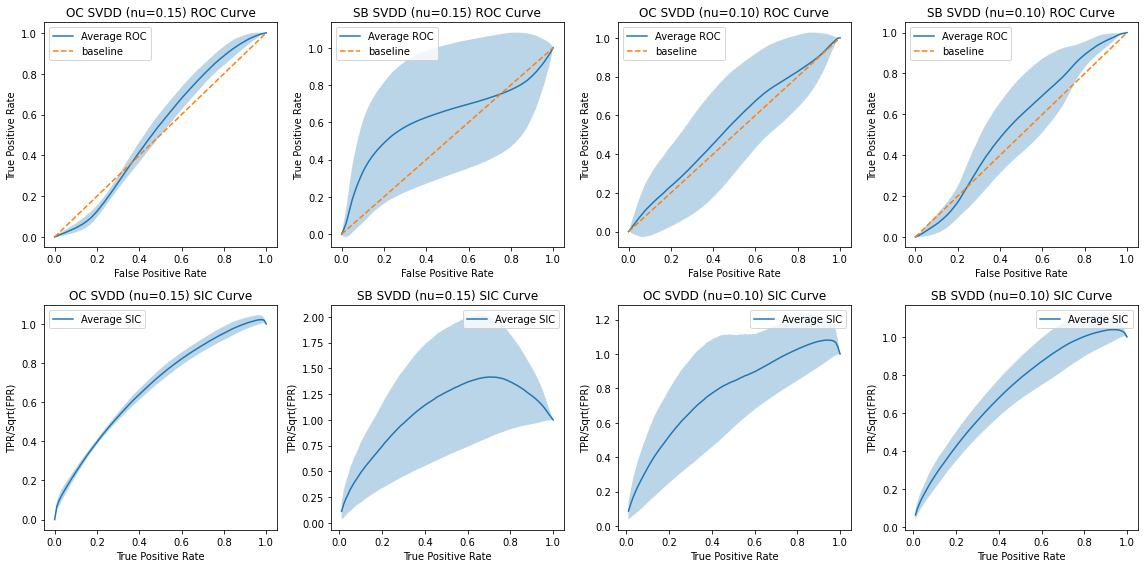

In [14]:
fig, axs = plt.subplots(2,4, figsize=(16,8))
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = axs

make_avg_plots(ax1,ax5, oc15_10_scores, y_test, "OC SVDD (nu=0.15)")
make_avg_plots(ax2,ax6, sb15_10_scores, y_test, "SB SVDD (nu=0.15)")
make_avg_plots(ax3,ax7, oc10_10_scores, y_test, "OC SVDD (nu=0.10)")
make_avg_plots(ax4,ax8, sb10_10_scores, y_test, "SB SVDD (nu=0.10)")

plt.tight_layout()
fig.show()

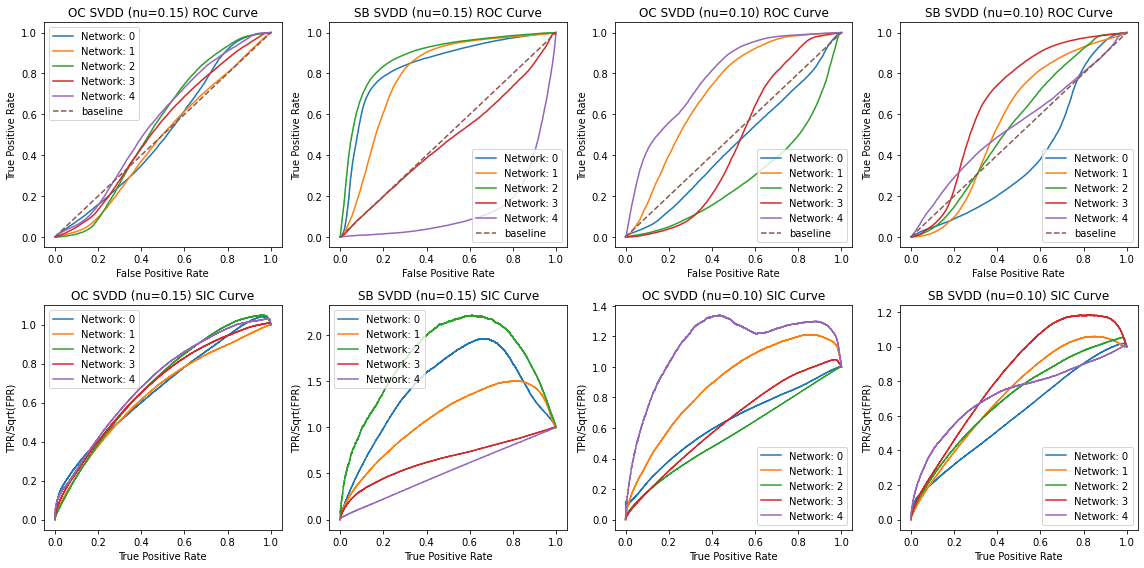

In [16]:
fig, axs = plt.subplots(2,4, figsize=(16,8))
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = axs

make_plots(ax1,ax5, oc15_10_scores, y_test, "OC SVDD (nu=0.15)")
make_plots(ax2,ax6, sb15_10_scores, y_test, "SB SVDD (nu=0.15)")
make_plots(ax3,ax7, oc10_10_scores, y_test, "OC SVDD (nu=0.10)")
make_plots(ax4,ax8, sb10_10_scores, y_test, "SB SVDD (nu=0.10)")

plt.tight_layout()
fig.show()

20 Epochs train

In [ ]:
oc15_20, oc15_20_scores = make_and_test_SVDD('one-class', nu=0.15)
oc10_20, oc10_20_scores = make_and_test_SVDD('one-class', nu=0.10)

sb15_20, sb15_20_scores = make_and_test_SVDD('one-class', nu=0.15)
sb10_20, sb10_20_scores = make_and_test_SVDD('one-class', nu=0.10)

  Epoch 10/20	 Time: 8.274	 Loss: 0.02743880

In [ ]:
np.save("saved_data/oc15_20_scores.npy", oc15_20_scores)
np.save("saved_data/oc10_20_scores.npy", oc10_20_scores)
np.save("saved_data/sb15_20_scores.npy", sb15_20_scores)
np.save("saved_data/sb10_20_scores.npy", sb10_20_scores)

In [17]:
oc15_20_scores = np.load("saved_data/oc15_20_scores.npy")
oc10_20_scores = np.load("saved_data/oc10_20_scores.npy")
sb15_20_scores = np.load("saved_data/sb15_20_scores.npy")
sb10_20_scores = np.load("saved_data/sb10_20_scores.npy")

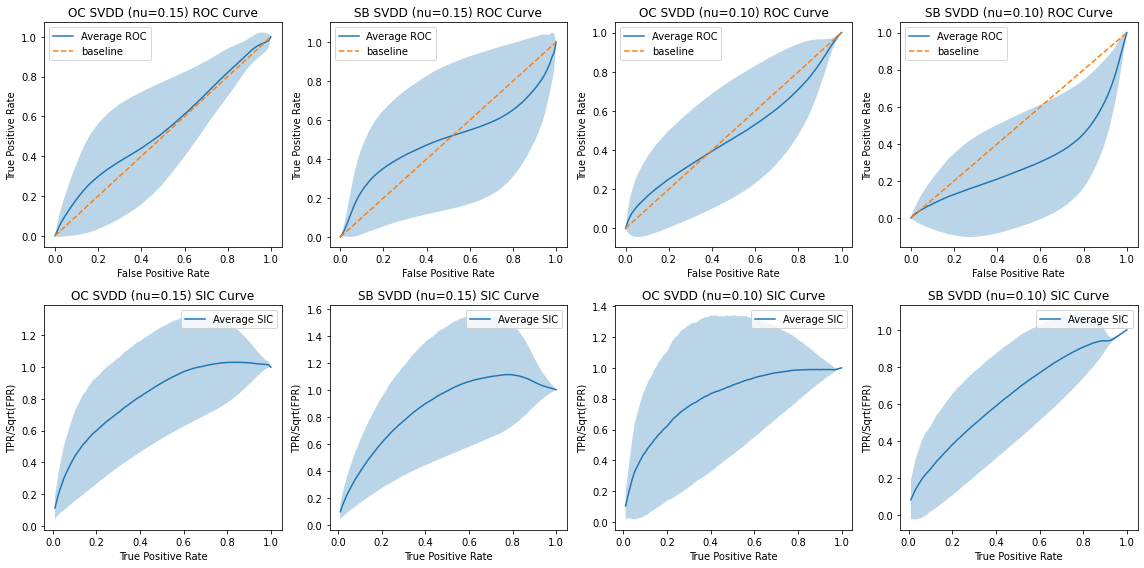

In [130]:
fig, axs = plt.subplots(2,4, figsize=(16,8))
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = axs

make_avg_plots(ax1,ax5, oc15_20_scores, y_test, "OC SVDD (nu=0.15)")
make_avg_plots(ax2,ax6, sb15_20_scores, y_test, "SB SVDD (nu=0.15)")
make_avg_plots(ax3,ax7, oc10_20_scores, y_test, "OC SVDD (nu=0.10)")
make_avg_plots(ax4,ax8, sb10_20_scores, y_test, "SB SVDD (nu=0.10)")

plt.tight_layout()
fig.show()

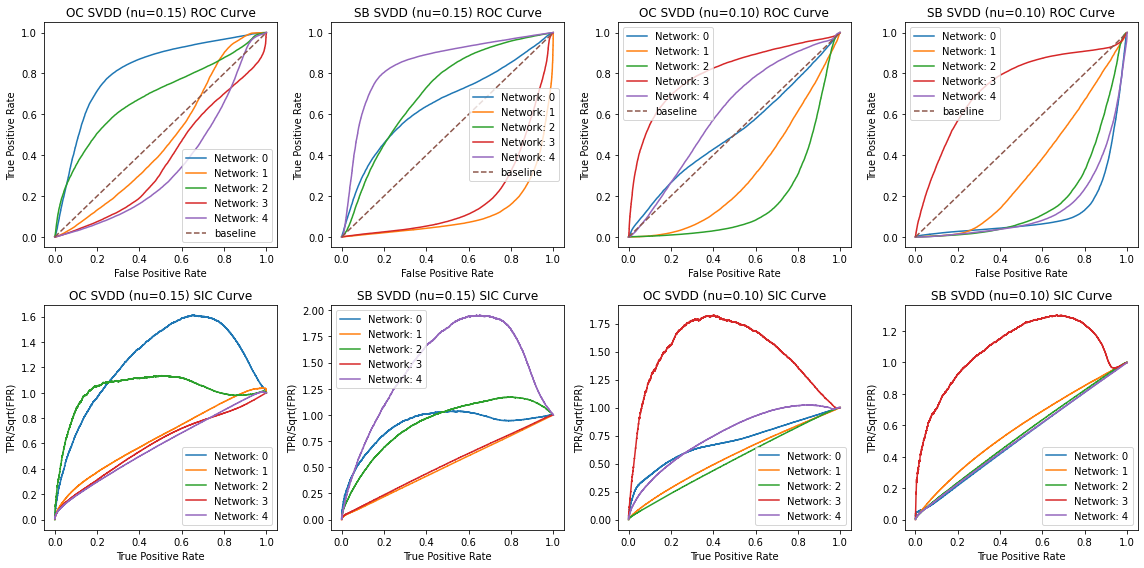

In [18]:
fig, axs = plt.subplots(2,4, figsize=(16,8))
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = axs

make_plots(ax1,ax5, oc15_20_scores, y_test, "OC SVDD (nu=0.15)")
make_plots(ax2,ax6, sb15_20_scores, y_test, "SB SVDD (nu=0.15)")
make_plots(ax3,ax7, oc10_20_scores, y_test, "OC SVDD (nu=0.10)")
make_plots(ax4,ax8, sb10_20_scores, y_test, "SB SVDD (nu=0.10)")

plt.tight_layout()
fig.show()

In [142]:
best_oc_svdd = oc10_20_scores[3]
best_sb_svdd = sb15_10_scores[2]

## OC SVM

In [22]:
from models.oc_svm import OAD, IAD

In [29]:
oad_models = OAD()
iad_models = IAD()

oad_test_scores = []
iad_test_scores = []

In [ ]:
oad.fit(X_train)
oad_test_scores.append(-oad.scores(X_test)+1)
    
np.save("saved_models/oad.npy", oad)

iad.fit(X_train)
iad_test_scores.append(iad.scores(X_test))

np.save("saved_models/iad.npy", iad)

 60%|██████    | 3/5 [56:56<37:40, 1130.16s/it]  

In [ ]:
np.save("saved_data/oad_scores.npy", oad_test_scores)
np.save("saved_data/iad_scores.npy", iad_test_scores)

In [37]:
oad_test_scores = np.load("saved_data/oad_scores.npy")
iad_test_scores = np.load("saved_data/iad_scores.npy")

In [38]:
oad_test_scores = [oad_test_scores[0]]
iad_test_scores = [iad_test_scores[0]]

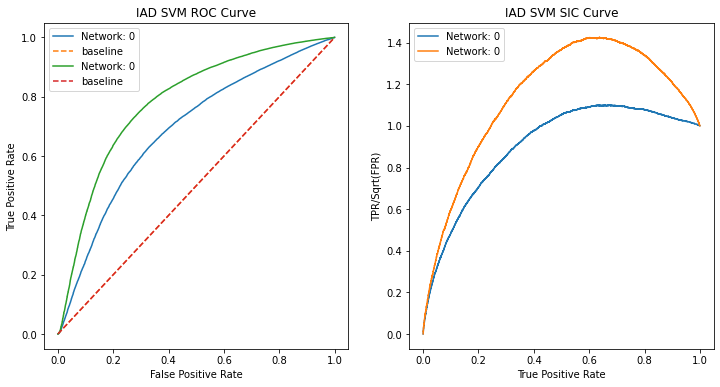

In [39]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
(ax1, ax2) = axs

make_plots(ax1,ax2, oad_test_scores, y_test, "OAD SVM")
make_plots(ax1,ax2, iad_test_scores, y_test, "IAD SVM")

fig.show()

# Autoencoder

In [40]:
def autoencoder():
    ae = Sequential()
    # Encoder Portion
    ae.add(Dense(512, input_dim=5, activation='relu'))
    ae.add(BatchNormalization())
    ae.add(Dense(512, activation='relu'))
    ae.add(Dense(2, activation='linear'))
    
    # Decoder Portion
    ae.add(Dense(512, input_dim=2, activation='relu'))
    ae.add(Dense(512, activation='relu'))
    ae.add(Dense(5, activation='relu'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    ae.compile(loss='mse', optimizer=optimizer)
    return ae

def reconstruction_error(ae_model, X):
    X_prime = ae_model(X)
    return np.linalg.norm(X-X_prime, axis=1)

In [41]:
ensemble = [autoencoder() for _ in range(5)]
histories = [ae.fit(X_train, X_train, epochs=1) for ae in ensemble]

2022-03-03 13:30:30.834835: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 13:30:42.920222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24135 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-03-03 13:30:42.921037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 32327 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-03-03 13:30:42.921693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 33251 MB

  30/3034 [..............................] - ETA: 16s - loss: 0.7793

2022-03-03 13:30:44.772716: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3034/3034 [==============================] - 15s 5ms/step - loss: 0.0646


In [42]:
autoencoder_scores = []
for i in range(len(ensemble)):
    ae = ensemble[i]
    test_events = reconstruction_error(ae, X_test)
    autoencoder_scores.append(test_events)

In [43]:
np.save("saved_data/autoencoder_scores.npy", autoencoder_scores)

In [ ]:
autoencoder_scores = np.load("saved_data/autoencoder_scores.npy")

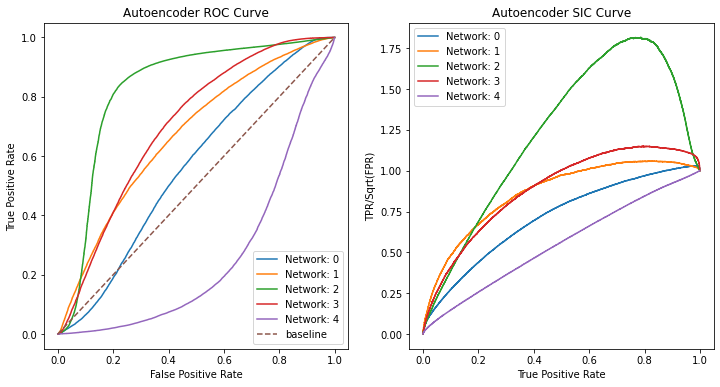

In [45]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
(ax1, ax2) = axs
make_plots(ax1, ax2, autoencoder_scores, y_test, "Autoencoder")
fig.show()

In [46]:
best_autoencoder = autoencoder_scores[2]

# Normal NN trained on one class

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, Dense, Flatten

In [147]:
def gaussian(x):
    return -np.e**(-x**2)+1

In [235]:
def train_classifier(X_train, y_train,epochs=5, gauss=False, reg=0.0):
    model = Sequential()
    model.add(Dense(128, input_dim=5, activation='relu', activity_regularizer=tf.keras.regularizers.L2(reg))) 
    model.add(Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.L2(reg)))
    model.add(Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.L2(reg)))
    if gauss:
        model.add(Dense(1, use_bias=True, activation='linear'))
        model.add(tf.keras.layers.Lambda(gaussian))
    else:
        model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=int(0.01*len(X_train)))
    return model

In [236]:
# reg
basic_nn_models_reg = [train_classifier(X_train, y_train, reg=0.02) for _ in range(5)]
basic_scores_per_model_reg = [model.predict(X_test) for model in basic_nn_models_reg]
sig_scores_per_model_reg = [model.predict(X_sig) for model in basic_nn_models_reg]
bg_test_scores_per_model_reg = [model.predict(X_bg_test) for model in basic_nn_models_reg]

Epoch 1/5
101/101 [==============================] - 1s 4ms/step - loss: 0.3569 - accuracy: 0.9900
Epoch 2/5
101/101 [==============================] - 0s 4ms/step - loss: 0.1244 - accuracy: 1.0000
Epoch 3/5
101/101 [==============================] - 0s 4ms/step - loss: 0.0810 - accuracy: 1.0000
Epoch 4/5
101/101 [==============================] - 0s 4ms/step - loss: 0.0620 - accuracy: 1.0000
Epoch 5/5
101/101 [==============================] - 0s 4ms/step - loss: 0.0507 - accuracy: 1.0000
Epoch 1/5
101/101 [==============================] - 1s 4ms/step - loss: 0.3572 - accuracy: 0.9900
Epoch 2/5
101/101 [==============================] - 0s 4ms/step - loss: 0.1145 - accuracy: 1.0000
Epoch 3/5
101/101 [==============================] - 0s 4ms/step - loss: 0.0744 - accuracy: 1.0000
Epoch 4/5
101/101 [==============================] - 0s 4ms/step - loss: 0.0592 - accuracy: 1.0000
Epoch 5/5
101/101 [==============================] - 0s 4ms/step - loss: 0.0500 - accuracy: 1.0000
Epoch 1/5


In [ ]:
basic_nn_models_sigmoid = [train_classifier(X_train, y_train) for _ in range(5)]
basic_scores_per_model_sigmoid = [model.predict(X_test) for model in basic_nn_models_sigmoid]
sig_scores_per_model_sigmoid = [model.predict(X_sig) for model in basic_nn_models_sigmoid]
bg_test_scores_per_model_sigmoid = [model.predict(X_bg_test) for model in basic_nn_models_sigmoid]

In [182]:
basic_nn_models_gaussian = [train_classifier(X_train, y_train, gauss=True) for _ in range(5)]
basic_scores_per_model_gaussian = [model.predict(X_test) for model in basic_nn_models_gaussian]
sig_scores_per_model_gaussian = [model.predict(X_sig) for model in basic_nn_models_gaussian]
bg_test_scores_per_model_gaussian = [model.predict(X_bg_test) for model in basic_nn_models_gaussian]
# bg_train_scores_per_model = [model.predict(X_train) for model in basic_nn_models]

Epoch 1/5
101/101 [==============================] - 1s 4ms/step - loss: 9.4878e-04 - accuracy: 1.0000
Epoch 2/5
101/101 [==============================] - 0s 4ms/step - loss: 9.1278e-07 - accuracy: 1.0000
Epoch 3/5
101/101 [==============================] - 0s 3ms/step - loss: 3.9070e-07 - accuracy: 1.0000
Epoch 4/5
101/101 [==============================] - 0s 4ms/step - loss: 2.2658e-07 - accuracy: 1.0000
Epoch 5/5
101/101 [==============================] - 0s 4ms/step - loss: 1.4818e-07 - accuracy: 1.0000
Epoch 1/5
101/101 [==============================] - 1s 4ms/step - loss: 6.0740e-04 - accuracy: 1.0000
Epoch 2/5
101/101 [==============================] - 0s 4ms/step - loss: 1.4903e-06 - accuracy: 1.0000
Epoch 3/5
101/101 [==============================] - 1s 5ms/step - loss: 5.0048e-07 - accuracy: 1.0000
Epoch 4/5
101/101 [==============================] - 0s 5ms/step - loss: 2.4113e-07 - accuracy: 1.0000
Epoch 5/5
101/101 [==============================] - 0s 5ms/step - loss: 

In [176]:
np.save("saved_data/basic_scores_per_model_gaussian_5.npy", basic_scores_per_model_gaussian)
np.save("saved_data/sig_scores_per_model_gaussian_5.npy", sig_scores_per_model_gaussian)
np.save("saved_data/bg_test_scores_per_model_gaussian_5.npy", bg_test_scores_per_model_gaussian)

In [119]:
np.save("saved_data/basic_scores_per_model_sigmoid.npy", basic_scores_per_model_sigmoid)
np.save("saved_data/sig_scores_per_model_sigmoid.npy", sig_scores_per_model_sigmoid)
np.save("saved_data/bg_test_scores_per_model_sigmoid.npy", bg_test_scores_per_model_sigmoid)

In [191]:
basic_scores_per_model = np.load("saved_data/basic_scores_per_model_10_epoch.npy")
sig_scores_per_model = np.load("saved_data/sig_scores_per_model_10_epoch.npy")
bg_test_scores_per_model = np.load("saved_data/bg_test_scores_per_model_10_epoch.npy")

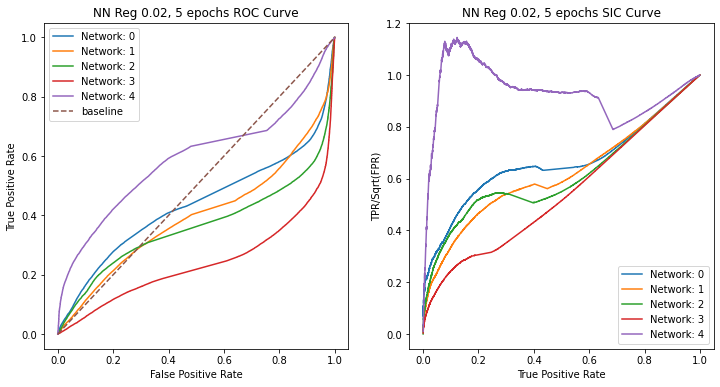

In [237]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
(ax1, ax2) = axs

make_plots(ax1, ax2, basic_scores_per_model_reg, y_test, "NN Reg 0.02, 5 epochs")
# make_avg_plots(ax1, ax2, basic_scores_per_model, "Basic NN")

fig.show()

In [66]:
# choose a median one for each model as well

In [238]:
best_nn = basic_scores_per_model[9]

In [239]:
i = 4
# best_gauss_nn = basic_scores_per_model_gaussian[i]
sig_scores = sig_scores_per_model_reg[i]
bg_test_scores = bg_test_scores_per_model_reg[i]
# bg_train_scores = bg_train_scores_per_model[i]

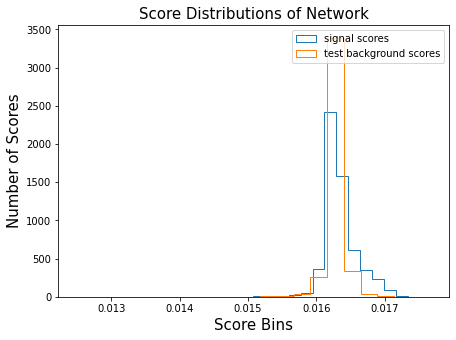

In [240]:
plt.figure(figsize=(7,5))
plt.hist(sig_scores[:], bins=20, histtype='step', density=True, label="signal scores")
plt.hist(bg_test_scores[:], bins=20, histtype='step', density=True, label="test background scores")
plt.title("Score Distributions of Network",fontsize=15)
plt.ylabel("Number of Scores",fontsize=15)
plt.xlabel("Score Bins", fontsize=15)
# axes[i,1].plot(X_train[:, i], bg_train_scores[:], 'x', label="train background scores")
plt.legend()
plt.show()

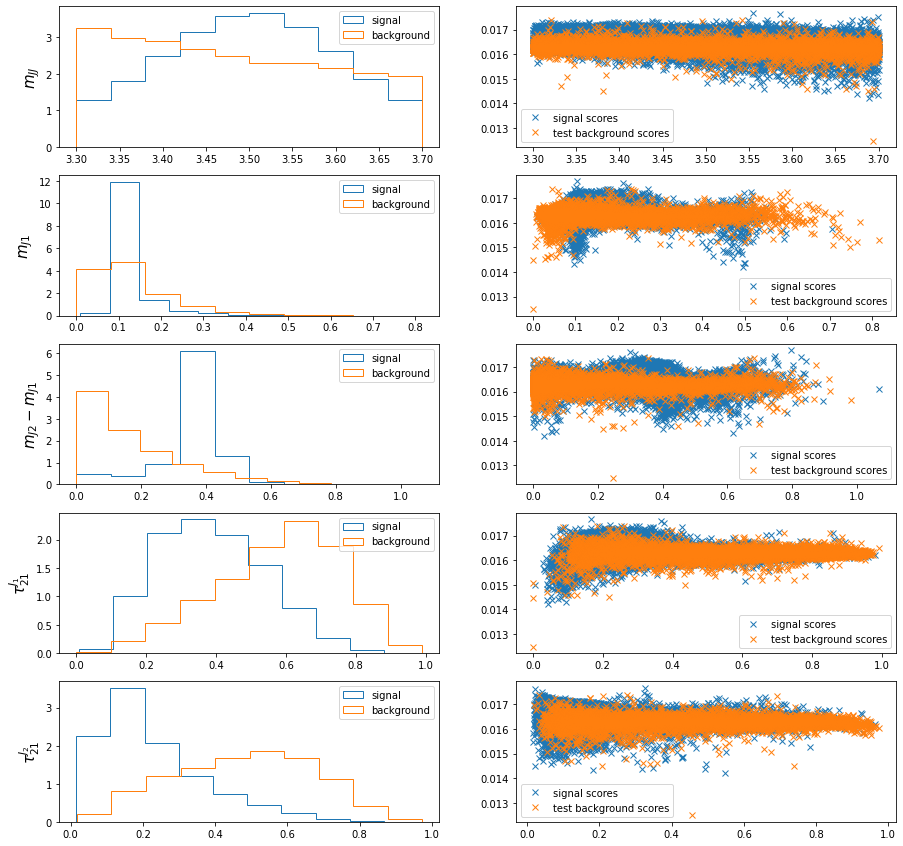

In [241]:
fig, axes = plt.subplots(5,2, figsize=(15,15))

axes[0,0].set_ylabel("$m_{JJ}$", fontsize=15)
axes[1,0].set_ylabel("$m_{J1}$", fontsize=15)
axes[2,0].set_ylabel("$m_{J2}-m_{J1}$", fontsize=15)
axes[3,0].set_ylabel("$\\tau_{21}^{J_{1}}$",fontsize=15)
axes[4,0].set_ylabel("$\\tau_{21}^{J_{2}}$",fontsize=15)

for i in range(5):
    axes[i,0].hist(X_sig[:, i], label="signal", density=True, histtype='step')
    axes[i,0].hist(X_bg_test[:, i],label="background", histtype='step', density=True)
    axes[i,0].legend()
    
    axes[i,1].plot(X_sig[:, i], sig_scores[:], 'x', label="signal scores")
    axes[i,1].plot(X_bg_test[:, i], bg_test_scores[:], 'x', label="test background scores")
    # axes[i,1].plot(X_train[:, i], bg_train_scores[:], 'x', label="train background scores")
    axes[i,1].legend()
plt.show()

# Final Plot

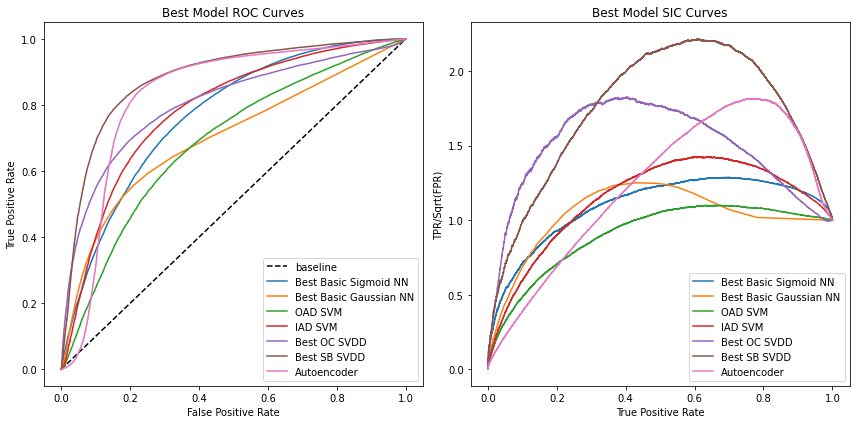

In [165]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

(ax1, ax2) = axs

ax1.set_title("Best Model ROC Curves")
ax2.set_title("Best Model SIC Curves")

ax1.plot([0,1],[0,1], '--k', label="baseline")

# OC basic NN
make_single_plot(ax1, ax2, best_nn, y_test, "Best Basic Sigmoid NN")
make_single_plot(ax1, ax2, best_gauss_nn, y_test, "Best Basic Gaussian NN")

# OC SVM
make_single_plot(ax1,ax2, oad_test_scores[0], y_test, "OAD SVM")
make_single_plot(ax1,ax2, iad_test_scores[0], y_test, "IAD SVM")

# OC SVDD
make_single_plot(ax1, ax2, best_oc_svdd, y_test, "Best OC SVDD")
make_single_plot(ax1, ax2, best_sb_svdd, y_test, "Best SB SVDD")

# Autoencoder
make_single_plot(ax1, ax2, best_autoencoder, y_test, "Autoencoder")

plt.tight_layout()
fig.show()

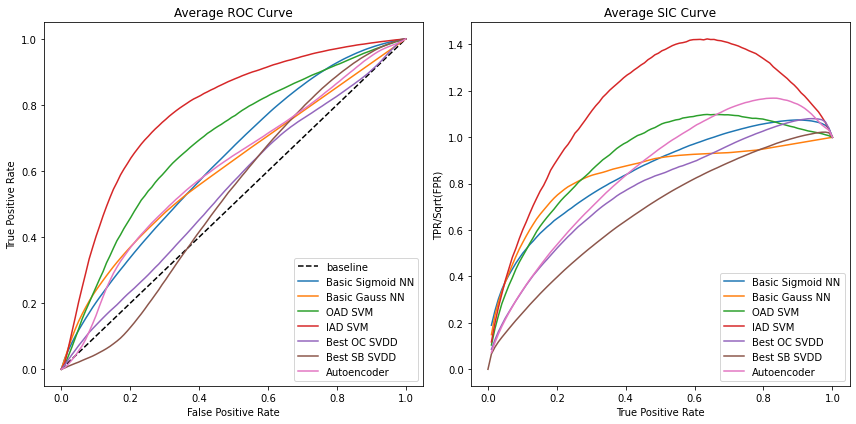

In [166]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

(ax1, ax2) = axs

ax1.plot([0,1],[0,1], '--k', label="baseline")

# OC basic NN
make_avg_plots(ax1, ax2, basic_scores_per_model, y_test, "Basic Sigmoid NN", baseline=False)
make_avg_plots(ax1, ax2, basic_scores_per_model_gaussian, y_test, "Basic Gauss NN", baseline=False)

# OC SVM
make_avg_plots(ax1,ax2, oad_test_scores, y_test, "OAD SVM", baseline=False)
make_avg_plots(ax1,ax2, iad_test_scores, y_test, "IAD SVM", baseline=False)

# OC SVDD
make_avg_plots(ax1, ax2, oc10_10_scores, y_test, "Best OC SVDD", baseline=False)
make_avg_plots(ax1, ax2, oc15_10_scores, y_test, "Best SB SVDD", baseline=False)

# Autoencoder
make_avg_plots(ax1, ax2, autoencoder_scores, y_test, "Autoencoder", baseline=False)

plt.tight_layout()
fig.show()